In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("Company Stock and Investment.csv")
data.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 5 columns):
Date                       1984 non-null object
Oil Investments            1984 non-null float64
Gold Investments           1984 non-null float64
Comp Stock                 1984 non-null float64
Other sharesInvestments    1984 non-null float64
dtypes: float64(4), object(1)
memory usage: 77.6+ KB


In [4]:
data['Date']=pd.to_datetime(data['Date'],format='%d-%m-%Y')

# Other sharesInvestments


In [5]:
#Lets consider the Gold Investments as our target and drop all others columns.

df=data.drop(columns=["Gold Investments","Oil Investments","Comp Stock"],axis=1)
df.head()

,Date,Other sharesInvestments
0,2009-12-31,0.006848
1,2010-01-04,-0.004609
2,2010-01-05,0.005900
3,2010-01-06,-0.018116
4,2010-01-07,-0.017013


In [6]:
# making date as my index column

df.set_index('Date',inplace=True)
df.head()

,Other sharesInvestments
Date,
2009-12-31,0.006848
2010-01-04,-0.004609
2010-01-05,0.005900
2010-01-06,-0.018116
2010-01-07,-0.017013


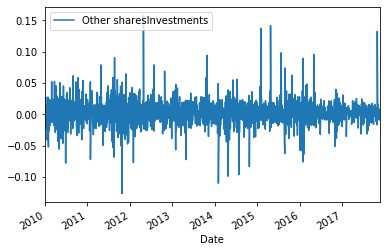

In [7]:
df.plot()

In [8]:
df.describe()

,Other sharesInvestments
count,1984.000000
mean,0.001269
std,0.019733
min,-0.126568
25%,-0.008492
50%,0.000840
75%,0.011632
max,0.157457


In [9]:
#check if data is stationarity or not

def adfuller_test(target):
    result=adfuller(target)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary")
    else:
        print("weak evidence against null hypothesis, time series is non-stationary ")

In [10]:
adfuller_test(df['Other sharesInvestments'])

ADF Test Statistic : -44.84814456404393
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 1983
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary


In [11]:
# average the daily stock value of gold investment for each month

y = df['Other sharesInvestments'].resample('MS').mean()
y['2009':]

Date
2009-12-01    0.006848
2010-01-01   -0.003520
2010-02-01   -0.002873
2010-03-01    0.006119
2010-04-01    0.000751
                ...   
2017-07-01    0.001102
2017-08-01   -0.000263
2017-09-01   -0.000943
2017-10-01    0.006737
2017-11-01    0.001773
Freq: MS, Name: Other sharesInvestments, Length: 96, dtype: float64

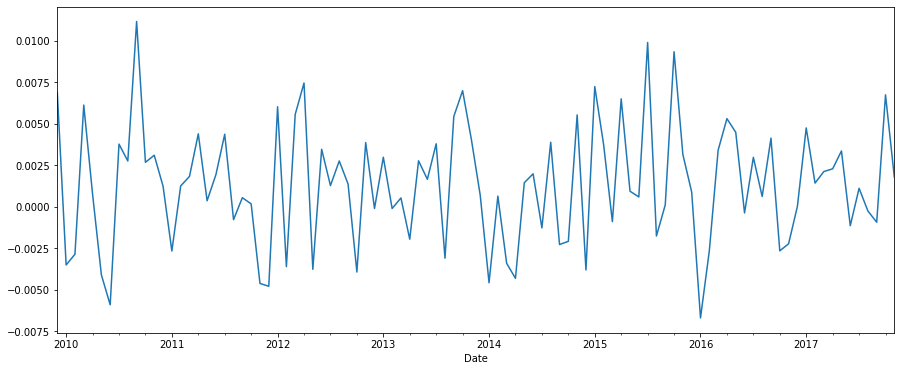

In [12]:
y.plot(figsize = (15, 6))

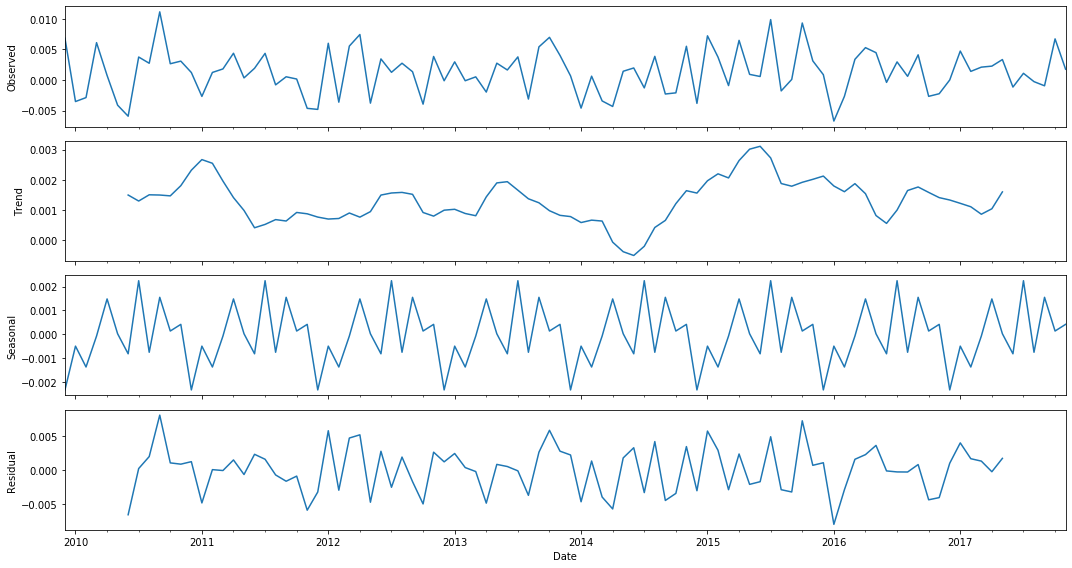

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

# Time series forecasting with ARIMA
Applying one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [14]:
# set the typical ranges for p, d, q
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
# Using Grid Search find the optimal set of parameters that yields the best performance
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False,enforce_invertibility=False) 
            result = mod.fit()   
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-790.9419182732419
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-789.6230617357521
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-627.0721369944487
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-671.8755626149882
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-789.8528926410361
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-787.0552049240516
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-660.4493510958912
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-667.8241062804434
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-789.3158564603725
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-782.2863141950442
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-625.3133946256348
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-670.0739560330488
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-788.4475839907906
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-785.4745748209334
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-658.6652749478857
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-666.0777920914073
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-723.7291544920091
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-725.141805

In [16]:
model = sm.tsa.statespace.SARIMAX(y, order = (1, 0, 1),seasonal_order = (0, 0, 1, 12))
result = model.fit()
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7196      0.339      2.122      0.034       0.055       1.384
ma.L1         -0.5948      0.385     -1.545      0.122      -1.350       0.160
ma.S.L12      -0.1487      0.130     -1.148      0.251      -0.403       0.105
sigma2       1.47e-05   2.36e-06      6.225      0.000    1.01e-05    1.93e-05


In [17]:
prediction = result.get_prediction(start = pd.to_datetime('2016-07-01'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci

,lower Other sharesInvestments,upper Other sharesInvestments
Date,,
2016-07-01,-0.008350,0.006681
2016-08-01,-0.006407,0.008624
2016-09-01,-0.006898,0.008133
2016-10-01,-0.008009,0.007022
2016-11-01,-0.007765,0.007266
2016-12-01,-0.007557,0.007474
2017-01-01,-0.006652,0.008379
2017-02-01,-0.006710,0.008321
2017-03-01,-0.007559,0.007472


# Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted stock value to real stock value of the time series, and we set forecasts to start at 2016–07–01 to the end of the data

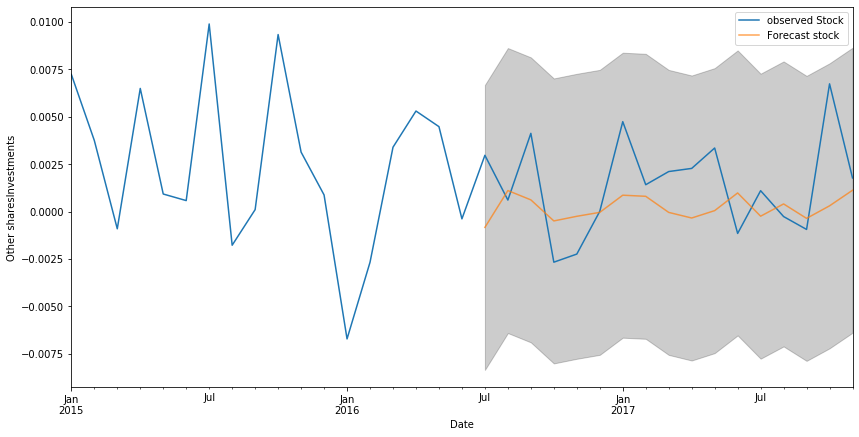

In [18]:
pred = result.get_prediction(start=pd.to_datetime('2016-07-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed Stock')
pred.predicted_mean.plot(ax=ax, label='Forecast stock', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Other sharesInvestments')
plt.legend()
plt.show()


# Making data for testing

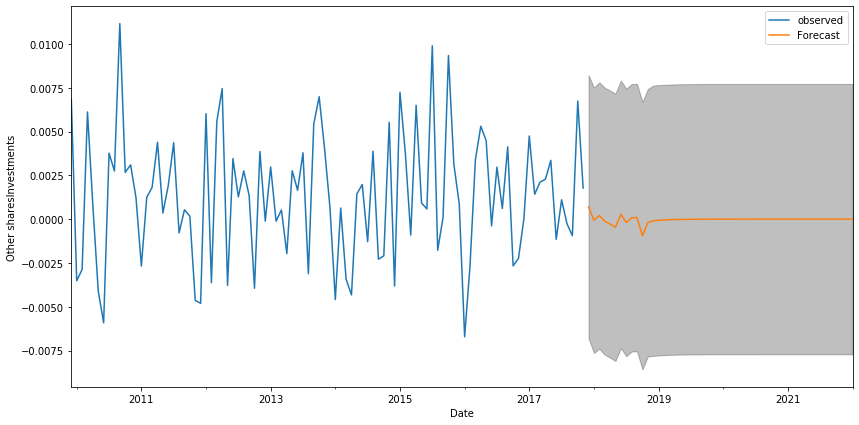

In [19]:
pred_uc = result.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Other sharesInvestments')
plt.legend()
plt.show()

Other invetment does not show any proper variation.Forecast reflect constant variation as we move further out into future